# Homework 3

## Imports


In [26]:
from collections import defaultdict
import random
import matplotlib.pyplot as plt

## The Edge Sample class


In [27]:
class EdgeSample:

    def __init__(self):
        self._store = {}
        self._num_edges = 0
        self._debug = True
        self._edge_set = set()

    def add(self, u, v):
        if u in self._store.keys():
            self._store[u].add(v)
        else:
            self._store[u] = set([v])

        if v in self._store.keys():
            self._store[v].add(u)
        else:
            self._store[v] = set([u])
        self._num_edges += 1
        self._edge_set.add((u, v))

    def delete(self, u, v):
        self._store[u].remove(v)
        set_u = self._store[u]
        if len(set_u) == 0:
            del self._store[u]

        self._store[v].remove(u)
        set_v = self._store[v]
        if len(set_v) == 0:
            del self._store[v]

        self._num_edges -= 1
        self._edge_set.remove((u, v))

    def get_neighbours(self, u):
        return self._store[u]

    def get_num_edges(self):
        return self._num_edges

    def get_vertice_list(self):
        return self._store.keys()

    def get_edges(self):
        return list(self._edge_set)


## The TRIEST-BASE class

Implements the reservoir sampling algorithm.


In [28]:
class TriestBase:

    def __init__(self, M):
        self._M = M
        self._S = EdgeSample()
        self._global_T = 0
        self._local_T = defaultdict(lambda: 0)
        self._debug = True

    def flip_coin(self, head_prob):
        coin_toss = random.random()
        if coin_toss < head_prob:
            return True
        else:
            return False

    # Updates local and global counters
    def update_counters(self, operation, u, v):
        vertices = self._S.get_vertice_list()
        if u not in vertices or v not in vertices:
            return
        neighbourhood_u = self._S.get_neighbours(u)
        neighbourhood_v = self._S.get_neighbours(v)

        shared_neigbourhood = neighbourhood_u & neighbourhood_v
        shared_value = len(shared_neigbourhood)

        if shared_value == 0:
            return

        if operation == '+':
            self._global_T += shared_value
            self._local_T[u] += shared_value
            self._local_T[v] += shared_value

            for c in shared_neigbourhood:
                self._local_T[c] += 1

        if operation == '-':
            self._global_T -= shared_value

            self._local_T[u] -= shared_value
            if self._local_T[u] == 0:
                del self._local_T[u]

            self._local_T[v] -= shared_value
            if self._local_T[v] == 0:
                del self._local_T[v]

            for c in shared_neigbourhood:
                self._local_T[c] -= 1
            if self._local_T[c] == 0:
                del self._local_T[c]

    # The reservoir sampling algorithm
    def sample_edge(self, t):
        if t <= self._M:
            return True
        else:
            coin_toss = self.flip_coin(self._M / t)
            if coin_toss:
                edge_list = self._S.get_edges()
                num_edges = len(edge_list)
                e_idx = random.randint(0, num_edges - 1)
                u1, v1 = edge_list[e_idx]
                self._S.delete(u1, v1)
                self.update_counters("-", u1, v1)

                return True

        return False

    def run(self, datafile):
        t = 0
        f = open(datafile)
        for line in f:
            u, v = line.split()
            t = t + 1
            if self.sample_edge(t):
                self._S.add(u, v)
                self.update_counters("+", u, v)

        print("m =", (self._M))
        global_triangles = int(self.estimate_triangles(t))
        print("Global Triangles =", (global_triangles))
        print("----------------------")
        return global_triangles

    def estimate_triangles(self, t):
        estimate = t * (t - 1) * (t - 2) / (self._M * (self._M - 1) *
                                            (self._M - 2))
        if estimate < 1:
            estimate = 1
        return int(estimate) * self._global_T


## The TRIEST-IMPR class

Implements the reservoir sampling algorithm.


In [29]:
class TriestImpr:

    def __init__(self, M):
        self._M = M
        self._S = EdgeSample()
        self._global_T = 0
        self._local_T = defaultdict(lambda: 0)
        self._debug = True

    def flip_coin(self, head_prob):
        coin_toss = random.random()
        if coin_toss < head_prob:
            return True
        else:
            return False

    # Updates local and global counters
    def update_counters(self, t, u, v):
        vertices = self._S.get_vertice_list()
        if u not in vertices or v not in vertices:
            return
        neighbourhood_u = self._S.get_neighbours(u)
        neighbourhood_v = self._S.get_neighbours(v)

        shared_neigbourhood = neighbourhood_u & neighbourhood_v
        shared_value = len(shared_neigbourhood)

        if shared_value == 0:
            return
        weight_t = ((t - 1) * (t - 2)) / (self._M * (self._M - 1))
        if weight_t < 1:
            weight_t = 1
        for c in shared_neigbourhood:
            self._local_T[c] += weight_t
            self._global_T += weight_t
            self._local_T[u] += weight_t
            self._local_T[v] += weight_t

    # The reservoir sampling algorithm
    def sample_edge(self, t):
        if t <= self._M:
            return True

        else:
            coin_toss = self.flip_coin(self._M / t)
            if coin_toss:
                edge_list = self._S.get_edges()
                num_edges = len(edge_list)
                e_idx = random.randint(0, num_edges - 1)
                u1, v1 = edge_list[e_idx]
                self._S.delete(u1, v1)
                return True

        return False

    def run(self, datafile):
        t = 0
        f = open(datafile)
        for line in f:
            u, v = line.split()
            t = t + 1
            self.update_counters(t, u, v)
            if self.sample_edge(t):
                self._S.add(u, v)

        print("m =", (self._M))
        print("Global Triangles =", (int(self._global_T)))
        print("----------------------")
        return int(self._global_T)


## Main


KeyError: '644135'

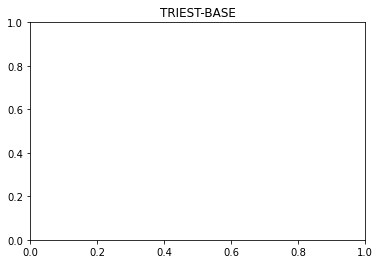

In [30]:
base = True  # Set True to use the TRIEST-BASE class, set False to use the TRIEST-IMPR class.
file_name = "data/web-NotreDame.txt"
M = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

triangle_counts = []
TRIANGLE_COUNT_GT = 1612010  # facebook_combined.txt actual number of triangles from https://snap.stanford.edu/data/ego-Facebook.html

for m in M:

    if base:
        model = TriestBase(m)
        plt.title("TRIEST-BASE")
    else:
        model = TriestImpr(m)
        plt.title("TRIEST-IMPR")

    count = model.run(file_name)
    triangle_counts.append(count)

plt.plot(M, triangle_counts)
plt.axhline(y=TRIANGLE_COUNT_GT, color='r', linestyle='-')
plt.xlabel("M")
plt.ylabel("Triangles")
plt.grid(True)
plt.show()


## Bonus tasks

1. What were the challenges you faced when implementing the algorithm?  
   * It was a bit difficult to understand the notations in the paper for the algorithm and hence it tooks some time to figure out how to implement the Edge Sample S.  
   * Tried implementing the TRIEST-FD, the third algorithm in the paper, but then opted for the TRIEST-IMPR algorithm since it was easier to implement.  
2. Can the algorithm be easily parallelized? If yes, how? If not, why? Explain.  
   It would be difficult to parallelize the algorithm since a lot of communication would be needed between the different processes for updating and synchronizinig the local and global counters. Some kind of partitioning algorithm would be nescessary for the graph and it could be quite complex to implement.
3. Does the algorithm work for unbounded graph streams? Explain.  
   
4. Does the algorithm support edge deletions? If not, what modification would it need? Explain.  
   Yes.
